In [48]:
!pip install pyarrow
!pip install torch-geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


In [ ]:
import torch
import pandas as pd
from torch_geometric.data import Data
from typing import Callable, Dict, Tuple, Optional

from itertools import combinations

In [50]:
import pyarrow.feather as feather

table = feather.read_table('dataset/data_andre.feather', memory_map=True)
df= table.to_pandas()
df.head()

,date,item_id,value,cat_label,sdep_label,dep_label,dmn_label,promo_type_FRPG,promo_value_FRPG,promo_type_GAS,...,promo_value_DISC,promo_type_CIRC,promo_value_CIRC,promo_type_CIRE,promo_value_CIRE,promo_type_CLCP,promo_value_CLCP,promo_type_LFPE,promo_value_LFPE,store_id
0,2021-01-23,27,8,refrigerated drnks,pos subd dairy other,pos dept dairy,cheese/yogurt/orange juice,0,0.0,0,...,0.0000,0,0.0,0,0.0,0,0.0,0,0.0,6269
1,2021-01-23,952568,6,carbonated sft drnks,pos subd grocery other,pos dept grocery,soda,0,0.0,0,...,0.0000,0,0.0,0,0.0,0,0.0,1,0.0,6269
2,2021-01-23,809,13,juices drnks shelf stbl,pos subd grocery other,pos dept grocery,juice/aseptic/new age,0,0.0,1,...,0.0000,0,0.0,0,0.0,0,0.0,0,0.0,6269
3,2021-01-23,20405,3,dairy chs,pos subd dairy other,pos dept dairy,cheese/yogurt/orange juice,0,0.0,0,...,0.1228,0,0.0,0,0.0,0,0.0,0,0.0,6269
4,2021-01-23,605573,5,refrigerated drnks,pos subd dairy other,pos dept dairy,cheese/yogurt/orange juice,0,0.0,0,...,0.0000,0,0.0,0,0.0,0,0.0,0,0.0,6269


In [51]:
df["store_id"].value_counts()

store_id
6269    1082371
Name: count, dtype: int64

In [52]:
len(df["item_id"].unique())

1427

In [53]:
df["item_id"].value_counts()

item_id
27        761
901498    761
6032      761
901555    761
6035      761
         ... 
79879     595
151824    591
210048    581
151827    578
151825    569
Name: count, Length: 1427, dtype: int64

In [54]:
df["date"] = pd.to_datetime(df["date"])
df["date"].unique()

<DatetimeArray>
['2021-01-23 00:00:00', '2021-01-24 00:00:00', '2021-01-25 00:00:00',
 '2021-01-26 00:00:00', '2021-01-27 00:00:00', '2021-01-28 00:00:00',
 '2021-01-29 00:00:00', '2021-01-30 00:00:00', '2021-01-31 00:00:00',
 '2021-02-01 00:00:00',
 ...
 '2023-02-13 00:00:00', '2023-02-14 00:00:00', '2023-02-15 00:00:00',
 '2023-02-16 00:00:00', '2023-02-17 00:00:00', '2023-02-18 00:00:00',
 '2023-02-19 00:00:00', '2023-02-20 00:00:00', '2023-02-21 00:00:00',
 '2023-02-22 00:00:00']
Length: 761, dtype: datetime64[ns]

In [61]:
df["cat_label"].unique()

array(['refrigerated drnks', 'carbonated sft drnks',
       'juices drnks shelf stbl', 'dairy chs', 'sprd btr mrgrn', 'yogurt',
       'rte cereal', 'sour cream', 'milknplant based bevs',
       'bottled water', 'dy non dy crm', 'eggs egg substitutes',
       'sparkling seltzer mixer', 'dairy cream', 'refrig dsrts',
       'refrigerated baked gds', 'new age bevs', 'hot cereal', 'itln chs',
       'sprt drnk', 'cottage chs', 'cream chs', 'dips refrigerated',
       'aseptic'], dtype=object)

In [60]:
from sklearn.preprocessing import LabelEncoder

enc_cat = LabelEncoder().fit(df["cat_label"])
enc_sdep = LabelEncoder().fit(df["sdep_label"])
enc_dep = LabelEncoder().fit(df["dep_label"])
enc_dmn = LabelEncoder().fit(df["dmn_label"])

df["cat_id"] = enc_cat.transform(df["cat_label"])
df["sdep_id"] = enc_sdep.transform(df["sdep_label"])
df["dep_id"] = enc_dep.transform(df["dep_label"])
df["dmn_id"] = enc_dmn.transform(df["dmn_label"])

# Edge Criterion: Spearman Correlation

# Edge Criterion: Positive Variance from the past day to the actual

In [ ]:
# after loading df with columns: date, item_id, value
dfx = df.copy()
dfx["date"] = pd.to_datetime(dfx["date"])

# aggregate to daily totals (safe even if already unique)
daily = (
    dfx.groupby(["date", "item_id"], as_index=False)["value"]
       .sum()
)

# sort and compute previous observation per item (not necessarily day-1 if gaps)
daily = daily.sort_values(["item_id", "date"])
daily["prev_value"] = daily.groupby("item_id")["value"].shift(1)

In [ ]:
def edges_positive_variation(g: pd.DataFrame, item_to_local: Dict[int, int]) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
    # keep items with prev_value available and positive delta
    mask = g["prev_value"].notna() & (g["value"] > g["prev_value"])
    inc_items = g.loc[mask, "item_id"].tolist()

    if len(inc_items) < 2:
        return torch.empty((2, 0), dtype=torch.long), None

    locs = [item_to_local[i] for i in inc_items]
    edge_list = []
    for a, b in combinations(locs, 2):
        edge_list.append((a, b))
        edge_list.append((b, a))  # undirected

    edge_index = torch.tensor(edge_list, dtype=torch.long).T
    return edge_index, None

In [55]:
from torch_geometric.utils import add_self_loops
def pyg_add_self_loops(edge_index, edge_weight=None, num_nodes=None):
   
    return add_self_loops(edge_index, edge_weight=edge_weight, num_nodes=num_nodes)

# Edge Criterion: Establish an edge between units

In [56]:

from itertools import combinations
def edges_equal_units(g: pd.DataFrame, item_to_local: Dict[int, int]):
    edge_list = []
    for v, sub in g.groupby("value"):
        locs = [item_to_local[i] for i in sub["item_id"].tolist()]
        if len(locs) >= 2:
            for i, j in combinations(locs, 2):
                edge_list.append((i, j))
                edge_list.append((j, i))
    if not edge_list:
        return torch.empty((2, 0), dtype=torch.long), None
    edge_index = torch.tensor(edge_list, dtype=torch.long).T
    return edge_index, None

# Spearman Correlation

In [57]:

EdgeFn = Callable[
    [pd.DataFrame, Dict[int, int]],
    Tuple[torch.Tensor, Optional[torch.Tensor]]  # (edge_index [2,E], edge_weight [E] or None)
]

NodeFeatFn = Callable[[pd.DataFrame], torch.Tensor]
def build_daily_graphs(
    df: pd.DataFrame,
    edge_fn: EdgeFn,
    node_feat_fn: Optional[NodeFeatFn] = None,
    add_self_loops: bool = False
):
    """
    Build one PyG Data per day using a pluggable edge function.
    df must contain: date, item_id, value (and any extra cols your edge_fn needs).
    """
    dfx = df.copy()
    dfx["date"] = pd.to_datetime(dfx["date"])

    # If you need metadata in g (e.g., cat_label/dep_label/dmn_label), include them here:
    keep_cols = ["date", "item_id", "value"]
    for col in ["cat_label", "dep_label", "dmn_label"]:
        if col in dfx.columns:
            keep_cols.append(col)

    daily = (
        dfx[keep_cols]
        .groupby(["date", "item_id"], as_index=False)
        .agg({**{"value": "sum"}, **{c: "first" for c in keep_cols if c not in ["date", "item_id", "value"]}})
    )

    graphs_by_date = {}

    for day, g in daily.groupby("date", sort=True):
        # Per-day nodes
        items = g["item_id"].to_numpy()
        item_to_local = {itm: i for i, itm in enumerate(items)}

        # Node features
        if node_feat_fn is None:
            x = torch.tensor(g["value"].to_numpy().reshape(-1, 1), dtype=torch.float32)
        else:
            x = node_feat_fn(g)  # must align with g’s row order (same as items)

        # Edges (+ optional weights)
        edge_index, edge_weight = edge_fn(g, item_to_local)

        # Optional self-loops
        if add_self_loops:
            if edge_weight is None:
                edge_index, edge_weight = pyg_add_self_loops(edge_index, num_nodes=len(items))
            else:
                edge_index, edge_weight = pyg_add_self_loops(edge_index, edge_weight=edge_weight, num_nodes=len(items))

        data = Data(
            x=x,
            edge_index=edge_index if edge_index.numel() else torch.empty((2, 0), dtype=torch.long),
            item_id=torch.tensor(items, dtype=torch.long),
            num_nodes=len(items),
        )
        if edge_weight is not None:
            data.edge_weight = edge_weight

        data.date_str = str(day.date())
        graphs_by_date[day] = data

    return graphs_by_date



In [58]:
graphs_by_date , edge_list = build_daily_graphs(df)


TypeError: build_daily_graphs() missing 1 required positional argument: 'edge_fn'

In [ ]:
first_day = next(iter(graphs_by_date))
print(first_day)
print(graphs_by_date[first_day])

2021-01-23 00:00:00
Data(x=[1262, 1], edge_index=[2, 136106], item_id=[1262], num_nodes=1262, date_str='2021-01-23')


In [ ]:
day = "2021-01-23"
item = 845

df.loc[(df["item_id"] == item) & (df["date"] == day), "value"]

Series([], Name: value, dtype: int32)

In [ ]:
from torch_geometric.utils import to_dense_adj

data = graphs_by_date[first_day]
A = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).squeeze(0)
print(A.shape)   # (num_nodes, num_nodes)
print(A)

torch.Size([1262, 1262])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.]])


Summary for variable A (dense adjacency):
  num_nodes: 1262
  num_edges: 68053
  density: 0.08552691936945372
  avg_degree: 107.84944152832031
  median_degree: 133.0
  min_degree: 0
  max_degree: 171
  std_degree: 57.43294143676758
  num_isolates: 22
  top_degree_nodes (idx -> deg):
    81 -> 171
    552 -> 171
    163 -> 171
    594 -> 171
    92 -> 171
    593 -> 171
    415 -> 171
    685 -> 171
    364 -> 171
    101 -> 171

Per-day graph statistics (first 10 rows):


,num_nodes,num_edges,density,avg_degree,median_degree,max_degree,num_isolates
date,,,,,,,
2021-01-23,1262,68053,0.085527,107.849442,133.0,171,22
2021-01-24,1363,66391,0.071526,97.418930,119.0,153,23
2021-01-25,1373,86509,0.091847,126.014565,155.0,190,22
2021-01-26,1378,140963,0.148577,204.590714,266.0,302,9
2021-01-27,1389,106533,0.110515,153.395248,172.0,248,20
2021-01-28,1398,102867,0.105342,147.163086,160.0,229,18
2021-01-29,1404,88796,0.090157,126.490028,161.0,197,20
2021-01-30,1405,57010,0.057801,81.153023,76.0,144,29
2021-01-31,1405,81783,0.082918,116.417084,133.0,190,16


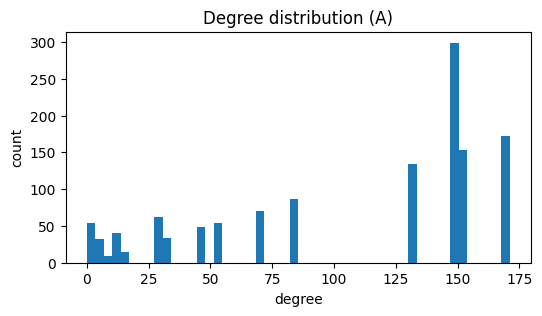

In [ ]:
import numpy as np


def summarize_dense_adj(A: torch.Tensor):
    """
    Compute basic statistics for a dense adjacency matrix A (torch.Tensor).
    Assumes undirected adjacency stored with both (i,j) and (j,i).
    """
    # ensure CPU and numpy-friendly
    A = A.detach().cpu().to(torch.float32)
    n = A.shape[0]
    # remove diagonal (self-loops) from counts for statistics
    A_nodiag = A.clone()
    A_nodiag.fill_diagonal_(0)
    # number of undirected edges
    total_edge_entries = A_nodiag.sum().item()           # counts both directions
    num_edges = int(total_edge_entries / 2)
    # degrees (counting each neighbor once)
    deg = A_nodiag.sum(dim=1).cpu().numpy()
    avg_deg = deg.mean()
    med_deg = np.median(deg)
    max_deg = deg.max()
    min_deg = deg.min()
    std_deg = deg.std()
    num_isolates = int((deg == 0).sum())
    possible_edges = n * (n - 1) / 2
    density = num_edges / possible_edges if possible_edges > 0 else 0.0

    hist_counts, hist_bins = np.histogram(deg, bins='auto')
    top_degrees = np.argsort(deg)[-10:][::-1]  # indices of up to 10 highest-degree nodes

    return {
        "num_nodes": n,
        "num_edges": num_edges,
        "density": density,
        "avg_degree": float(avg_deg),
        "median_degree": float(med_deg),
        "min_degree": int(min_deg),
        "max_degree": int(max_deg),
        "std_degree": float(std_deg),
        "num_isolates": num_isolates,
        "degree_hist_counts": hist_counts,
        "degree_hist_bins": hist_bins,
        "top_degree_node_indices": top_degrees,
        "top_degree_values": deg[top_degrees].tolist(),
    }



In [ ]:
# Quick single-matrix summary for the existing variable `A`
summary_A = summarize_dense_adj(A)
print("Summary for variable A (dense adjacency):")
for k, v in summary_A.items():
    if k.startswith("degree_hist_") or k.startswith("top_"):
        continue
    print(f"  {k}: {v}")
print("  top_degree_nodes (idx -> deg):")
for idx, deg in zip(summary_A["top_degree_node_indices"], summary_A["top_degree_values"]):
    print(f"    {int(idx)} -> {int(deg)}")

Summary for variable A (dense adjacency):
  num_nodes: 1262
  num_edges: 68053
  density: 0.08552691936945372
  avg_degree: 107.84944152832031
  median_degree: 133.0
  min_degree: 0
  max_degree: 171
  std_degree: 57.43294143676758
  num_isolates: 22
  top_degree_nodes (idx -> deg):
    81 -> 171
    552 -> 171
    163 -> 171
    594 -> 171
    92 -> 171
    593 -> 171
    415 -> 171
    685 -> 171
    364 -> 171
    101 -> 171



Per-day graph statistics (first 10 rows):


,num_nodes,num_edges,density,avg_degree,median_degree,max_degree,num_isolates
date,,,,,,,
2021-01-23,1262,68053,0.085527,107.849442,133.0,171,22
2021-01-24,1363,66391,0.071526,97.418930,119.0,153,23
2021-01-25,1373,86509,0.091847,126.014565,155.0,190,22
2021-01-26,1378,140963,0.148577,204.590714,266.0,302,9
2021-01-27,1389,106533,0.110515,153.395248,172.0,248,20
2021-01-28,1398,102867,0.105342,147.163086,160.0,229,18
2021-01-29,1404,88796,0.090157,126.490028,161.0,197,20
2021-01-30,1405,57010,0.057801,81.153023,76.0,144,29
2021-01-31,1405,81783,0.082918,116.417084,133.0,190,16


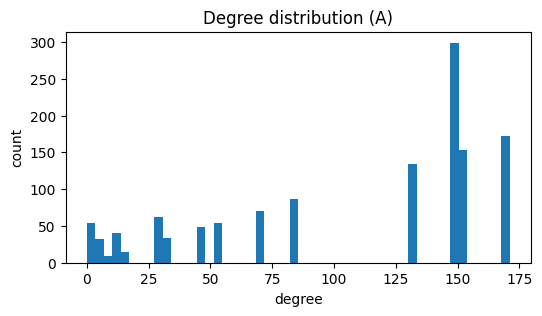

In [ ]:


# Build a per-day summary DataFrame using graphs_by_date (if available)
if 'graphs_by_date' in globals():
    rows = []
    for day, data in sorted(graphs_by_date.items()):
        # build dense adjacency for this day's graph (to_dense_adj already imported in notebook)
        dense = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).squeeze(0)
        s = summarize_dense_adj(dense)
        s["date"] = day
        rows.append(s)

    df_graph_stats = pd.DataFrame(rows).set_index("date").sort_index()
    # show a compact set of columns
    display_cols = ["num_nodes", "num_edges", "density", "avg_degree", "median_degree", "max_degree", "num_isolates"]
    print("\nPer-day graph statistics (first 10 rows):")
    display(df_graph_stats[display_cols].head(10))
else:
    print("graphs_by_date is not available in this environment.")

# Optional: show degree distribution plot for A (requires matplotlib; will use if already available)
try:
    import matplotlib.pyplot as plt
    deg = (A.clone().cpu().to(torch.float32).fill_diagonal_(0).sum(dim=1).numpy())
    plt.figure(figsize=(6,3))
    plt.hist(deg, bins=50)
    plt.title("Degree distribution (A)")
    plt.xlabel("degree")
    plt.ylabel("count")
    plt.show()
except Exception:
    pass